# Sentiment Analysis on amazon product reviews

In this project we will attempt to create a model to predict whether a review is positive or negative. For this we have used the amazon product dataset from https://nijianmo.github.io/amazon/index.html we use the small book dataset as the large ones will be too much for our project.

In [19]:
#Importing libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import json
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Making a class of reviews to store so that accessing the text and the score is easier.

In [9]:
class Sentiment:
    positive = 'POSITIVE'
    neutral = 'NEUTRAL'
    negative = 'NEGATIVE'

class Review:
    def __init__(self,text,score):
        self.text = text
        self.score= score
        self.sentiment = self.get_sentiment(score)

    def get_sentiment(self,score):
        if score <= 2:
            return Sentiment.negative
        elif score == 3:
            return Sentiment.neutral
        else:
            return Sentiment.positive

def distribute(reviews):
    neg_reviews = list(filter(lambda x: x.sentiment == Sentiment.negative, reviews))
    pos_reviews = list(filter(lambda x: x.sentiment == Sentiment.positive, reviews))
    neu_reviews = list(filter(lambda x: x.sentiment == Sentiment.neutral, reviews))

    min_length = min([len(neg_reviews),len(pos_reviews),len(neu_reviews)])
    max_obs = int(min_length + (0.2*min_length))
    #We will keep the number of positive ratings 20% more than negatives, so that we don't lose important data due to class balancing
    #We could use something like SMOTE but that will be too much for this project
    if len(neg_reviews) != min_length and (len(neg_reviews) > max_obs):
        neg_reviews = neg_reviews[:max_obs]
    if (len(pos_reviews) != min_length) and (len(pos_reviews) > max_obs):
        pos_reviews = pos_reviews[:max_obs]
    if len(neu_reviews) != min_length and (len(neu_reviews) > max_obs):
        neu_reviews = neu_reviews[:max_obs]
    
    new_reviews = pos_reviews+neg_reviews+neu_reviews

    random.shuffle(new_reviews)
    
    return new_reviews


Reading data from the json file into a list of Review objects.

In [13]:
file = './data/sentiment/Books_small_10000.json'
reviews = []
with open(file) as f:
    for line in f:
        review = json.loads(line)
        reviews.append(Review(review['reviewText'],review['overall']))

In [14]:
temp1 = list(filter(lambda x : x.sentiment == Sentiment.positive, reviews))
temp2 = list(filter(lambda x : x.sentiment == Sentiment.neutral, reviews))
temp3 = list(filter(lambda x : x.sentiment == Sentiment.negative, reviews))
print(f'Number of positive reviews: {len(temp1)}')
print(f'Number of neutral reviews: {len(temp2)}')
print(f'Number of negative reviews: {len(temp3)}')

Number of positive reviews: 8378
Number of neutral reviews: 978
Number of negative reviews: 644


We see that there is a class imbalance problem in our dataset, this would cause our model to be trained for predicting only one class. We will implement a method to shrink the positive observations to have a bit more balanced dataset.

Let's use the distribute method to balance the data

In [15]:
reviews = distribute(reviews)

Now lets see the new distribution

In [16]:
temp1 = list(filter(lambda x : x.sentiment == Sentiment.positive, reviews))
temp2 = list(filter(lambda x : x.sentiment == Sentiment.neutral, reviews))
temp3 = list(filter(lambda x : x.sentiment == Sentiment.negative, reviews))
print(f'Number of positive reviews: {len(temp1)}')
print(f'Number of neutral reviews: {len(temp2)}')
print(f'Number of negative reviews: {len(temp3)}')

Number of positive reviews: 772
Number of neutral reviews: 772
Number of negative reviews: 644


Splitting the data into Train and Test data.


In [17]:
train, test = train_test_split(reviews,train_size=0.8,random_state=7)

train_x = [x.text for x in train]
train_y = [x.sentiment for x in train]

test_x = [x.text for x in train]
test_y = [x.sentiment for x in train]

## Vectorizing inputs

In [20]:
#vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()

train_x_vec = vectorizer.fit_transform(train_x) #TODO: try setting ngram_range to bi-gram (2,2)

test_x_vec = vectorizer.fit_transform(test_x)

## Training models

### Support Vector Machine

In [21]:
from sklearn.svm import SVC

svc = SVC(kernel='linear')

svc.fit(train_x_vec,train_y)

SVC(kernel='linear')

In [22]:
svc.predict(test_x_vec[11])

array(['POSITIVE'], dtype='<U8')

In [76]:
test_y[11]

'POSITIVE'

### Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(train_x_vec.toarray(),train_y)

GaussianNB()

In [24]:
nb.predict(test_x_vec[11].toarray())

array(['POSITIVE'], dtype='<U8')

### Decision Trees

In [25]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(train_x_vec,train_y)

DecisionTreeClassifier()

In [ ]:
dt.predict(test_x_vec[11])

array(['NEGATIVE'], dtype='<U8')

### KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_x_vec,train_y)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn.predict(test_x_vec[11])

array(['NEUTRAL'], dtype='<U8')

### Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(train_x_vec,train_y)

RandomForestClassifier()

In [ ]:
rf.predict(test_x_vec[11])

array(['NEGATIVE'], dtype='<U8')

## Evaluating Models

In [32]:
#Mean Accuracy of models
print(f'SVM: {svc.score(test_x_vec,test_y)}')
print(f'nb: {nb.score(test_x_vec.toarray(),test_y)}')
print(f'dt: {dt.score(test_x_vec,test_y)}')
print(f'knn: {knn.score(test_x_vec,test_y)}')
print(f'rf: {rf.score(test_x_vec,test_y)}')

SVM: 0.9377142857142857
nb: 0.9245714285714286
dt: 1.0
knn: 0.7234285714285714
rf: 1.0


In [33]:
#Checking the F1 score
from sklearn.metrics import f1_score

print(f1_score(test_y, svc.predict(test_x_vec), average=None,labels=[Sentiment.positive,Sentiment.neutral,Sentiment.negative]))
print(f1_score(test_y, nb.predict(test_x_vec.toarray()), average=None,labels=[Sentiment.positive,Sentiment.neutral,Sentiment.negative]))
print(f1_score(test_y, dt.predict(test_x_vec), average=None,labels=[Sentiment.positive,Sentiment.neutral,Sentiment.negative]))
print(f1_score(test_y, knn.predict(test_x_vec), average=None,labels=[Sentiment.positive,Sentiment.neutral,Sentiment.negative]))
print(f1_score(test_y, rf.predict(test_x_vec), average=None,labels=[Sentiment.positive,Sentiment.neutral,Sentiment.negative]))

[0.95162569 0.92709984 0.93346981]
[0.94912427 0.92658228 0.89605735]
[1. 1. 1.]
[0.77408907 0.69771529 0.69387755]
[1. 1. 1.]


## Confusion matrix for SVM

<AxesSubplot: >

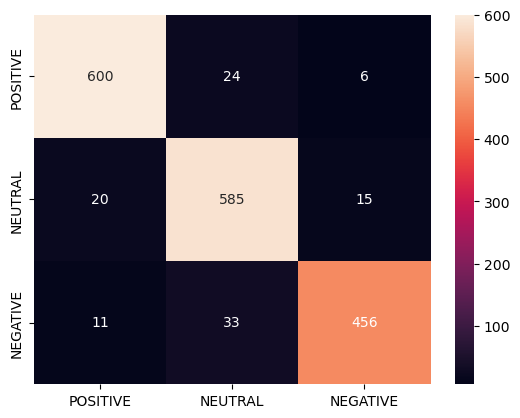

In [41]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = svc.predict(test_x_vec)
labels = [Sentiment.positive,Sentiment.neutral,Sentiment.negative]
matrix = confusion_matrix(test_y,y_pred,labels = labels)
df_cm = pd.DataFrame(matrix,index=labels,columns = labels)

sns.heatmap(df_cm,annot=True,fmt='d')
sns.

This is the confusion matrix for the SVM model where the rows indicate true values while the columns show the predicted valeus.

## Tuning the model with Grid Search

In [35]:
from sklearn.model_selection import GridSearchCV

parameter = {'kernel': ('linear','rbf','poly'),'degree':(1,2,3),'C':(1.0,3.0,0.5,2.0)}

svm = SVC()
clf = GridSearchCV(svc,parameter,cv=5)
clf.fit(train_x_vec,train_y)

GridSearchCV(cv=5, estimator=SVC(kernel='linear'),
             param_grid={'C': (1.0, 3.0, 0.5, 2.0), 'degree': (1, 2, 3),
                         'kernel': ('linear', 'rbf', 'poly')})

We can see the best parameters for the svm classifier. We will export the sm with these parameters

## Saving the model

In [37]:
import pickle 

#Saving the svm model
with open('./models/sentiment_rf_classifier.pkl','wb') as f:
    pickle.dump(rf,f)

#Saving the random forest model
with open('./models/sentiment_svm_classifier.pkl','wb') as f:
    pickle.dump(svc,f)